In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
#open dataset and add paths to array
import pathlib
paths =[]
for path in pathlib.Path("Dataset\mask_weared_incorrect").iterdir():
    #print(path)
    paths.append(path)
for path in pathlib.Path("Dataset\with_mask").iterdir():
    #print(path)
    paths.append(path)
for path in pathlib.Path("Dataset\without_mask").iterdir():
    #print(path)
    paths.append(path)

#check length of paths array to see if all data was copied(8982 files)    
print(len(paths))

8982


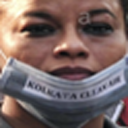

In [31]:
#incorrect_mask = list(paths.glob('mask_weared_incorrect/*'))
PIL.Image.open(paths[0])

In [39]:
#define parameters for the loader
batch_size = 32
img_height = 128
img_width = 128
directory = "Dataset/"

None


In [40]:
#create training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8982 files belonging to 3 classes.
Using 7186 files for training.


In [41]:
#create test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


In [42]:
#print the class name
class_names = train_dataset.class_names
print(class_names)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [43]:
#configure for better preformance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
#Standardize the images ideal to neural network
rescale_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [45]:
#create the model
number_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_classes)
])

In [46]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
early_stop = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)       

In [49]:
#train the model
epochs=100
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/100
225/225 [==============================] - 42s 174ms/step - loss: 0.3359 - accuracy: 0.8665 - val_loss: 0.3031 - val_accuracy: 0.8836
Epoch 2/100
225/225 [==============================] - 39s 175ms/step - loss: 0.1449 - accuracy: 0.9502 - val_loss: 0.1655 - val_accuracy: 0.9454
Epoch 3/100
225/225 [==============================] - 39s 174ms/step - loss: 0.0964 - accuracy: 0.9665 - val_loss: 0.1069 - val_accuracy: 0.9633
Epoch 4/100
225/225 [==============================] - 39s 172ms/step - loss: 0.0596 - accuracy: 0.9809 - val_loss: 0.0972 - val_accuracy: 0.9671
Epoch 5/100
225/225 [==============================] - 39s 175ms/step - loss: 0.0313 - accuracy: 0.9908 - val_loss: 0.1077 - val_accuracy: 0.9666
Epoch 6/100
225/225 [==============================] - 39s 174ms/step - loss: 0.0307 - accuracy: 0.9905 - val_loss: 0.2363 - val_accuracy: 0.9154
Epoch 7/100
225/225 [==============================] - 40s 179ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.1189 -

In [50]:
model_df = pd.DataFrame(model.history.history)
model_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.335850,0.866546,0.303064,0.883630
1,0.144880,0.950181,0.165457,0.945434
2,0.096400,0.966463,0.106948,0.963252
3,0.059637,0.980935,0.097208,0.967149
4,0.031329,0.990815,0.107686,0.966592


<AxesSubplot:>

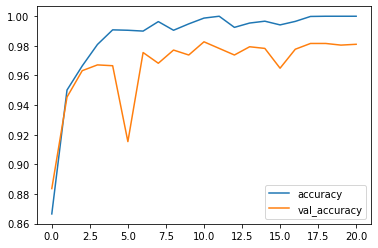

In [51]:
model_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

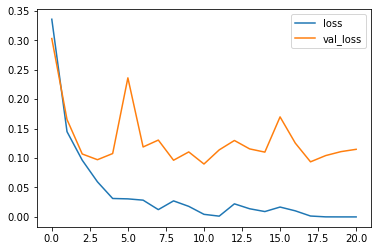

In [52]:
model_df[['loss','val_loss']].plot()

In [53]:
model.save("my_model.h5")